In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from multiprocessing import cpu_count

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

In [2]:
df = pd.read_csv("data/midterm-S2024-problem3-backup.csv")

In [3]:
df = df.drop("set", axis = 1)
df

,y,x.1,x.2,x.3,x.4,x.5,x.6,x.7,x.8,x.9,...,x.21,x.22,x.23,x.24,x.25,x.26,x.27,x.28,x.29,x.30
0,1,0.441808,0.492796,0.652985,0.570000,0.535837,0.249446,0.258391,0.293467,0.775666,...,1.368359,0.726319,0.578838,0.854195,1.446671,3.916411,1.653749,2.879529,1.710699,1.412465
1,1,0.527473,1.147165,1.215030,1.313042,2.234302,0.396754,0.622855,0.619991,0.573381,...,2.016211,2.243127,1.421153,2.880565,2.961876,3.463201,1.833477,2.700372,2.619264,2.486096
2,1,0.808467,1.018147,1.052657,0.971518,1.338531,0.362469,1.230537,0.884234,1.739904,...,2.855277,2.836080,8.637734,2.312735,3.011210,3.420881,2.159914,1.463965,1.996372,2.094663
3,0,0.018449,1.722087,1.239744,1.255812,1.450954,0.878937,0.892702,1.161845,1.361301,...,1.838953,1.264322,2.563714,1.535393,2.915544,1.986144,1.458378,1.660463,3.029658,3.719193
4,0,0.455411,0.597902,1.029035,1.060215,1.104696,1.763757,2.236051,2.061531,2.078233,...,4.156158,1.971198,3.669656,3.637963,2.046006,2.557524,2.340380,2.302548,1.662722,3.089054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109995,0,0.512598,0.646134,0.817301,0.809074,1.553680,2.352803,2.506754,2.531563,2.552342,...,1.233467,1.653878,2.643867,1.238920,1.771586,2.217136,1.762736,2.376266,1.832085,1.460128
109996,1,0.157099,0.312489,0.982980,1.543461,1.429240,0.908283,1.269034,1.049590,1.411398,...,1.623148,1.029015,1.474622,1.427536,3.342370,1.425786,3.390089,1.596189,1.197290,1.170944
109997,0,0.951924,1.228070,1.505550,1.554526,1.531873,0.546093,1.221872,1.337283,1.282420,...,3.127744,1.659361,1.351739,1.472651,1.355497,1.097287,2.359522,1.887610,1.310082,1.721514
109998,0,0.584386,0.912777,2.022678,1.820919,1.303641,0.295491,0.798284,2.259362,1.138350,...,1.460057,1.455049,1.395379,1.268198,2.731178,1.830794,1.673268,1.944939,1.471292,1.414113


In [24]:
#FUNCTIONS

#METRICS

def mspe(preds, gt):
    """Calculates the mean squared prediction error between a list of predictions, preds, and a list of ground truth labels, gt."""
    if len(preds) != len(gt): return ValueError("predictions and ground-truth vectors must be the same length!")
    preds,gt = preds.tolist(),gt.tolist()
    sse = sum([(gt[i] - preds[i])**2 for i in range(len(gt))])
    return sse/len(gt)

#PARALLELIZE

def all_models_repK(df: pd.DataFrame, n_repeats: int, n_splits: int):
    """Runs n_repeats repetitions of k-fold cross validations where k=n_splits."""
    scores = {}
    metrics = {
        "mspe": make_scorer(mspe),
    }
    for model in [LogisticRegression(), LinearRegression()]:
        X,y = df.drop("y", axis=1),df["y"] #assuming only X and y are present.
        rkf = RepeatedKFold(n_repeats=n_repeats,n_splits=n_splits)
        score = cross_validate(model, X, y, cv=rkf, scoring=metrics)
        scores[str(model)] = score
    return scores

#define high-level parallelization
def make_groups(num_reps: int, num_jobs: int):
    """Divides num_reps by num_jobs such that no group is more than one larger than another."""
    r = num_reps%num_jobs
    groupsize = int(num_reps/num_jobs)
    groups = []
    for i in range(num_jobs):
        if r > 0:
            groups.append(groupsize+1)
            r-=1
        else:
            groups.append(groupsize)
    return groups

def run_jobs(n_jobs: int, df: pd.DataFrame, n_repeats: int=10, n_splits: int=10):
    """High-level function which parallelizes all_models_repK for n_jobs."""
    reps = make_groups(n_repeats, n_jobs)
    results = Parallel(n_jobs=n_jobs)(delayed(all_models_repK)(df, r, n_splits) for r in reps)
    return results

def aggregate_partitioned_results(scores: list):
    """Brings partitioned data back together under a model->metric->values dictionary structure."""
    model_results = {str(model_name):{"mspe":[]} for model_name in [LogisticRegression(),LinearRegression()]}
    for partition_n,partition_data in enumerate(scores):
        for model_n,model_name in enumerate(partition_data.keys()): #model_n is 0 indexed
            model_results[model_name]["mspe"].extend(partition_data[model_name]["test_mspe"])
    return model_results

In [31]:
cpu_count()

8

In [32]:
scores = run_jobs(5, df, 10, 10)

In [ ]:
model_results = aggregate_partitioned_results(scores)

In [44]:
model_results

{'LogisticRegression()': {'mspe': [0.1370909090909091,
   0.1338181818181818,
   0.1360909090909091,
   0.1369090909090909,
   0.13136363636363638,
   0.13036363636363638,
   0.13218181818181818,
   0.136,
   0.13418181818181818,
   0.13227272727272726,
   0.1348181818181818,
   0.13445454545454547,
   0.13527272727272727,
   0.12963636363636363,
   0.1300909090909091,
   0.13727272727272727,
   0.13363636363636364,
   0.13363636363636364,
   0.14063636363636364,
   0.13145454545454546,
   0.1388181818181818,
   0.1359090909090909,
   0.13545454545454547,
   0.13345454545454546,
   0.13545454545454547,
   0.12718181818181817,
   0.13445454545454547,
   0.13318181818181818,
   0.13090909090909092,
   0.13345454545454546,
   0.1310909090909091,
   0.1340909090909091,
   0.1320909090909091,
   0.13672727272727273,
   0.1358181818181818,
   0.13545454545454547,
   0.1318181818181818,
   0.13363636363636364,
   0.13654545454545455,
   0.13172727272727272,
   0.1388181818181818,
   0.1349090

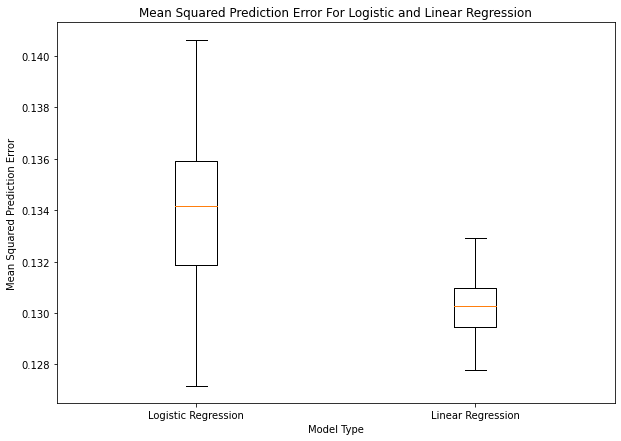

In [58]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

plt.boxplot([model_results['LogisticRegression()']['mspe'],model_results['LinearRegression()']['mspe']])
ax.set_xticklabels(['Logistic Regression', 'Linear Regression'])
plt.xlabel("Model Type")
plt.ylabel("Mean Squared Prediction Error")
plt.title("Mean Squared Prediction Error For Logistic and Linear Regression")
plt.savefig("plots/mspe_loglin.png")

For 2a, you should set up the problem the same way you did in HW4 under `utils.py`! You can embed the metric into the repk technique.

TODO:
- get right # of cpus X
- confirm your functions work X 
- paste code back to parallelize.py X
- draw boxplots 
- onto 2b